<a href="https://colab.research.google.com/github/FarahBouattour/knowWhatToEat/blob/main/univariate_lstm_cnn_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###univariate time series LSTM first try

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
print(tf.__version__)

2.5.0


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

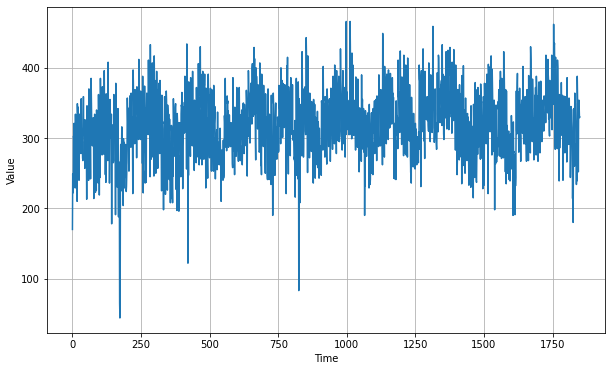

In [4]:
#df = pd.read_csv('reffined_data.csv')
df = pd.read_csv('data_pca_dt_covid_fi.csv')
df = df.iloc[:1850]

series = np.array(df['flux_journalier'])
#time_step = np.array(df['Date'])
time = np.array([i for i in range(len(df))]) 
plt.figure(figsize=(10, 6))
plot_series(time, series)

Clean data by removing the three pics from the series

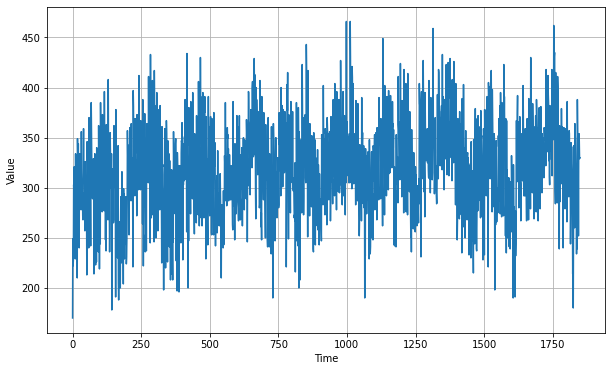

In [5]:
denoised_series = [i if i>150 else 200 for i in list(series)]

plt.figure(figsize=(10, 6))
plot_series(time, denoised_series)

In [6]:
denoised_series = np.array(denoised_series)

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(denoised_series.reshape(-1,1))
series = scaler.transform(denoised_series.reshape(-1,1))


split_time = 1250  #600
time_train = time[:split_time]
x_train = series[:split_time] 
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 7 # 30 slices worth of data, so we're splitting the x_train 30 times !!!
batch_size = 30

print('total',series.shape)
print('train',x_train.shape)
print('test', x_valid.shape)

total (1850, 1)
train (1250, 1)
test (600, 1)


In [8]:
# Window dataset, we're going to use it on x_train
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1) # This is required since we have specified a specific input function in the model
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
# We take the DNN model, and we try to apply it to our series use the window technique
# So after training it will help us forecast
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    # No map or shuffle, this was done in the windowed_dataset()
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

batch_size = 128
shuffle_buffer = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer) # We take a window of x_train
print("train_set= ",train_set)
print("\n x_train.shape= ",x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]), # We have specified the input shape here so we need to change the windowed_dataset()
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.SimpleRNN(512, return_sequences=True),
  tf.keras.layers.SimpleRNN(32, return_sequences=True),
  tf.keras.layers.Dense(60, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

# The whole purpose of this cell is to know which learning rate to use using the lr_schedule
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=20, callbacks=[lr_schedule])


train_set=  <PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>

 x_train.shape=  (1250, 1)
Epoch 1/20
10/10 [==============================] - 5s 74ms/step - loss: 0.5067 - mae: 0.8318
Epoch 2/20
10/10 [==============================] - 1s 66ms/step - loss: 0.2357 - mae: 0.5628
Epoch 3/20
10/10 [==============================] - 1s 65ms/step - loss: 0.1719 - mae: 0.4578
Epoch 4/20
10/10 [==============================] - 1s 65ms/step - loss: 0.1079 - mae: 0.3497
Epoch 5/20
10/10 [==============================] - 1s 68ms/step - loss: 0.0596 - mae: 0.2574
Epoch 6/20
10/10 [==============================] - 1s 64ms/step - loss: 0.0405 - mae: 0.2147
Epoch 7/20
10/10 [==============================] - 1s 66ms/step - loss: 0.0320 - mae: 0.1912
Epoch 8/20
10/10 [==============================] - 1s 68ms/step - loss: 0.0262 - mae: 0.1748
Epoch 9/20
10/10 [==============================] - 1s 66ms/step - loss: 0.0236 - mae: 0.1675
Epoch 10/20
10

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
print("1",scaler.inverse_transform(np.squeeze(rnn_forecast)))
print(rnn_forecast.shape)
rnn_forecast = rnn_forecast[split_time - window_size:-1,-1,0] 
print("\n2",np.array(rnn_forecast.shape))

1 [[318.26456 312.0736  310.22525 ... 314.072   240.48724 286.7029 ]
 [318.00833 312.59894 316.92233 ... 291.53738 293.46387 311.83383]
 [318.38678 311.92706 314.42917 ... 299.78485 290.57135 271.33023]
 ...
 [318.74698 317.50192 326.20294 ... 322.2666  327.56036 323.9331 ]
 [318.2646  316.8672  324.10126 ... 331.69296 333.98743 346.27203]
 [318.1038  316.24045 323.55875 ... 318.61887 328.76224 350.2234 ]]
(1844, 7, 1)

2 [600]


In [12]:
#results['Date'] = df['Date']
pred = pd.DataFrame(scaler.inverse_transform(rnn_forecast.reshape(-1,1)))
real = pd.DataFrame(scaler.inverse_transform(x_valid))

results = pd.concat([real,pred, real-pred], axis = 1)
#results = results.rename(columns={0: ('flux_réel', 'prediction')})
print('Max = ', max(results.iloc[:,2]))
print([int(i) for i in list(results.iloc[:,2])])

Max =  145.2093505859375
[-4, -39, -6, -43, -38, -51, -37, -41, -30, -39, -50, -66, -4, -36, 82, 61, 74, 88, 44, 31, -67, -9, -16, -67, 5, 8, -4, 23, 40, 49, 3, -36, -25, -27, -135, 26, 18, -11, 25, -30, 37, 18, -45, -9, -33, -22, -23, -47, -52, 52, 6, -33, -39, 1, -61, -15, 59, 12, -14, 14, 0, -2, -33, 54, 94, 16, 33, 2, 2, -5, -69, 31, -22, -70, -28, -70, -2, -70, -68, -10, 56, 5, 2, -31, 126, 109, 44, 0, -17, -14, -11, -28, -37, -10, 17, 15, 1, -22, 96, -20, -15, 76, 18, -72, 29, 36, 18, -72, 16, 27, 39, -17, 56, 18, -76, -17, 24, -6, -37, 73, -12, 28, -12, 7, -7, -27, 65, 39, 6, 79, 66, -7, 47, -17, -10, -18, -47, -14, -16, -35, 116, -62, -7, 44, 6, -35, 17, 26, -1, -128, -24, -41, -98, -75, 0, 47, 10, 24, -1, 41, -29, 5, -59, -4, 29, 0, 50, -48, 20, -130, 32, -25, 16, -34, -77, 46, 29, -18, 27, -31, 30, -51, -48, 3, 3, -6, -37, -19, -12, -29, -19, -28, -13, -80, -40, -88, -11, -81, -29, -20, -6, -27, -70, -2, -17, -39, -9, -73, -23, -46, -89, -121, 31, 11, -18, -50, -79, 81, 99, -

(600,)
(600, 1)
(600,)


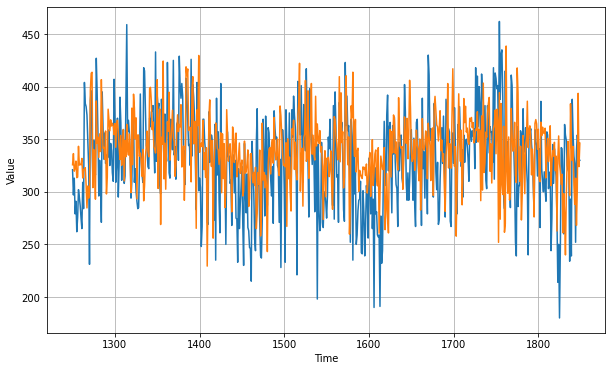

In [13]:
print(time_valid.shape)      
print(x_valid.shape)         
print(rnn_forecast.shape)    
plt.figure(figsize=(10, 6))
title = str("Forecasting with LSTM")
plot_series(time_valid, scaler.inverse_transform(x_valid)) # 2-D
plot_series(time_valid, scaler.inverse_transform(rnn_forecast.reshape(-1,1))) # we only took the last part of the rnn_forecast


In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy() # CNN LSTM 1.77

array([0.09977932, 0.15274008, 0.11403657, 0.2055727 , 0.16976674,
       0.25928432, 0.21483184, 0.13956475, 0.15831487, 0.18146573,
       0.21794808, 0.24959165, 0.12274276, 0.19038692, 0.2240358 ,
       0.16337718, 0.15488936, 0.13352442, 0.09051458, 0.09428865,
       0.36286023, 0.17208052, 0.19903855, 0.0870766 , 0.12274276,
       0.08953737, 0.09689911, 0.10823725, 0.2994818 , 0.19903855,
       0.09654427, 0.15550217, 0.08927136, 0.11830218, 0.23051392,
       0.19596423, 0.10451034, 0.08851092, 0.09797989, 0.09206319,
       0.08625973, 0.08783681, 0.08722529, 0.10273807, 0.09428865,
       0.0870766 , 0.08517522, 0.10467345, 0.12050097, 0.23356013,
       0.12841655, 0.12274276, 0.0931264 , 0.12593494, 0.15831487,
       0.09206319, 0.18091655, 0.11658858, 0.11830218, 0.09272814,
       0.10273807, 0.12501217, 0.11009759, 0.17501491, 0.4074289 ,
       0.09947164, 0.12114375, 0.09947164, 0.08585853, 0.16114146,
       0.12050097, 0.09947164, 0.12593494, 0.12274276, 0.09831